# Предварительная Настройка

In [1]:
import os, shutil
if os.path.exists('DNN'):
    shutil.rmtree("DNN")
!git clone https://github.com/Belashov641618/DNN.git

!pip install belashovplot
from belashovplot.belashovplot import DefaultFont, DefaultBigHeader, DefaultHeader, DefaultDefault, DefaultCaption, DefaultSmallCaption
DefaultFont['font'] = 'DejaVu Sans'
for Font in [DefaultBigHeader, DefaultHeader, DefaultDefault, DefaultCaption, DefaultSmallCaption]:
  Font.Font = 'DejaVu Sans'

Cloning into 'DNN'...
remote: Enumerating objects: 848, done.
remote: Counting objects: 100% (182/182), done.
remote: Compressing objects: 100% (125/125), done.
remote: Total 848 (delta 101), reused 92 (delta 48), pack-reused 666
Receiving objects: 100% (848/848), 37.62 MiB | 29.79 MiB/s, done.
Resolving deltas: 100% (456/456), done.
  Preparing metadata (setup.py) ... - done
  Created wheel for belashovplot: filename=belashovplot-1.0-py3-none-any.whl size=12758 sha256=30b46efa1b58502fbf4c8e4e91a08b93824e1c358c10088390143a607acdde5c
  Stored in directory: /root/.cache/pip/wheels/55/7b/e2/e5bf08c4c48d0989afbcb220497fa4bb6805a32f6c7826eece
Successfully built belashovplot


In [2]:
import DNN

from DNN.src.modules import layers
from DNN.src.modules import models
from DNN.src import utilities

from DNN.src.utilities import Format, CycleTimePredictor
from DNN.src.utilities.UniversalTestsAndOther import GenerateSingleUnscaledSampleMNIST

import torch
import torchvision
from torchvision.transforms.functional import resize, pad
from torchvision.transforms import InterpolationMode
import numpy
import math
import scipy
from itertools import product
from belashovplot import TiledPlot
import matplotlib.pyplot as plt

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


# Проверка распределения случайного шума

In [3]:
def distribution(a:torch.Tensor, N:int=100):
    values = torch.linspace(a.min(), a.max(), N+1)[1:]
    results = torch.zeros((N), dtype=torch.float32, device=a.device)
    for i, value in enumerate(values):
        results[i] = torch.sum(a <= value)
    results /= a.numel()
    return results

In [4]:
def generate(mask:torch.Tensor):
    random = torch.ones(mask.size(), dtype=mask.dtype, device=mask.device) * torch.exp(2j * torch.pi * torch.rand(mask.size(), dtype=mask.dtype, device=mask.device) - 1j*torch.pi)
    result = torch.sqrt(torch.abs(torch.fft.fftshift(torch.fft.ifft2(mask * random))))
    return (result - result.min()) / (result.max() - result.min())

In [5]:
def show(kernel:torch.Tensor, title:str=None, samples:int=100, N:int=256):
    with torch.no_grad():
        dist = torch.zeros((N), dtype=torch.float32, device=kernel.device)
        for i in range(samples):
            realization = generate(kernel)
            dist += distribution(realization, N)
        dist /= samples
            
    kwargs = {'aspect':'auto', 'cmap':'viridis', 'extent':[-1, 1]*2}         
    plot = TiledPlot(16, 9)
    if title is not None: plot.title(title)
    
    axes = plot.axes.add(0,0)
    axes.imshow(kernel.cpu(), **kwargs)
    plot.description.column.top('Маска образа', 0)
    
    axes = plot.axes.add(1,0)
    axes.imshow(realization.cpu(), **kwargs)
    plot.description.column.top('Реализация', 1)
    
    axes = plot.axes.add(2,0)
    axes.plot(numpy.linspace(0, 1, N), dist.cpu())
    axes.grid(True)
    plot.description.column.top('Распределение', 2)
    
    plot.show()

In [6]:
N = 512
samples = 100

with torch.no_grad():
    x_mesh, y_mesh = torch.meshgrid(torch.linspace(-1, +1, N, device=device), torch.linspace(-1, +1, N, device=device))
    r_mesh = torch.sqrt(x_mesh**2 + y_mesh**2)
    phi_mesh = torch.atan2(y_mesh, x_mesh)

/opt/conda/lib/python3.10/site-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /usr/local/src/pytorch/aten/src/ATen/native/TensorShape.cpp:3526.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


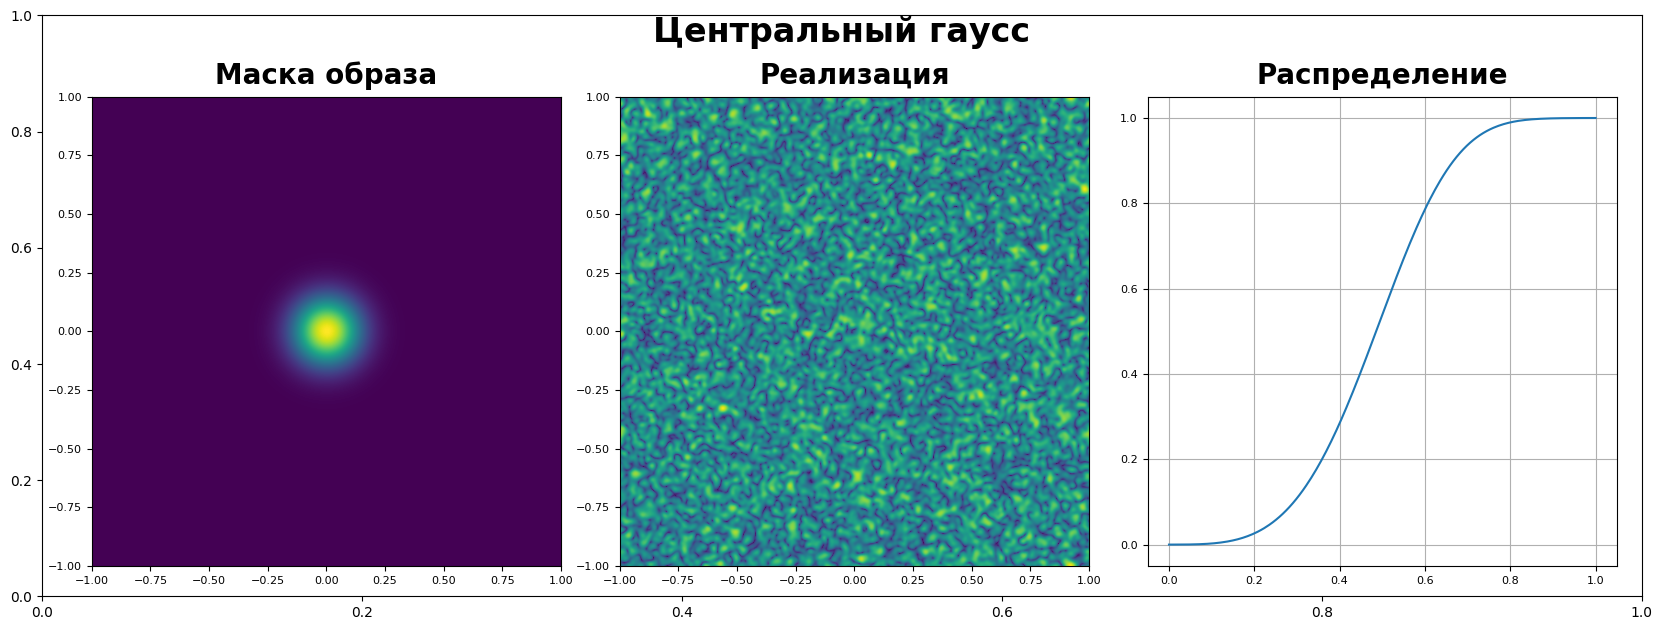

In [7]:
sigma = 0.1
kernel = torch.exp(-0.5*(r_mesh/sigma)**2) / (sigma * math.sqrt(2*math.pi))
show(kernel, samples=samples, title='Центральный гаусс')

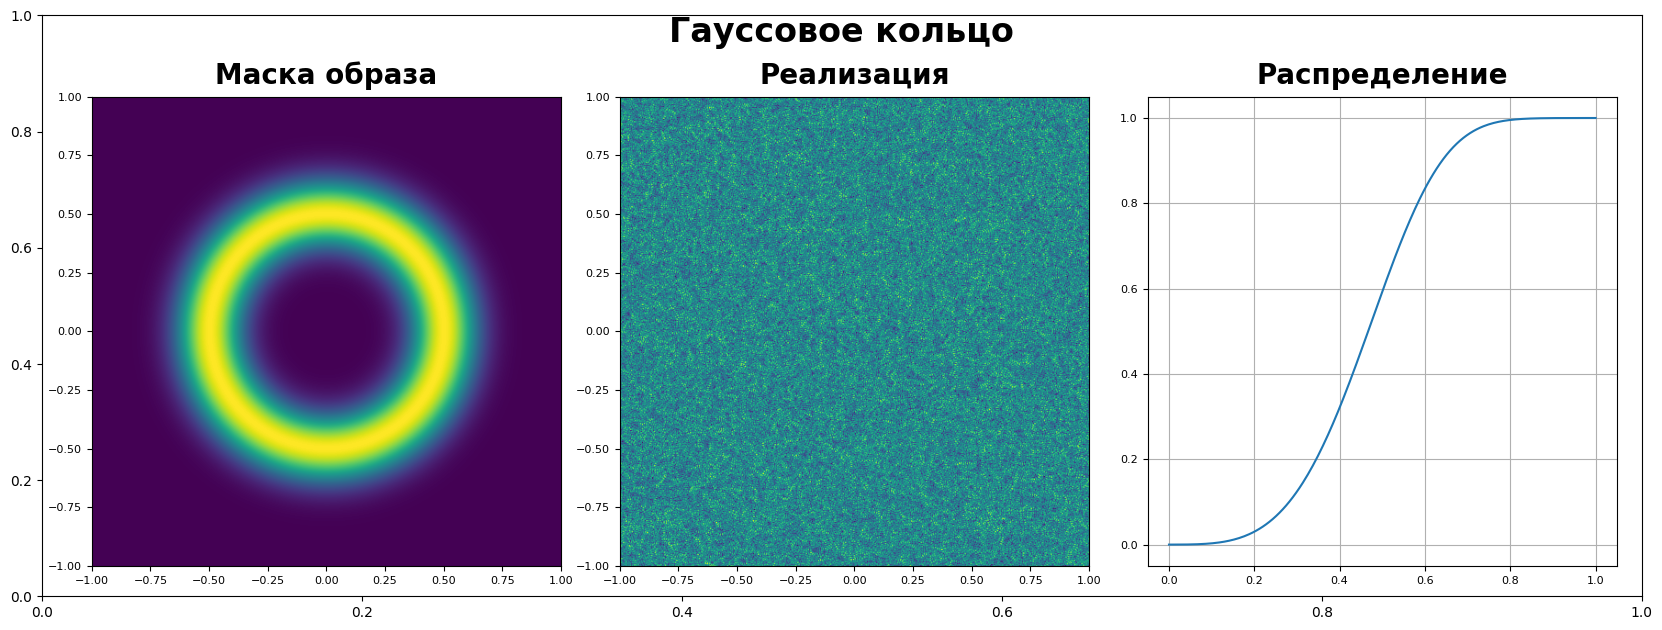

In [8]:
sigma = 0.1
r0 = 0.5
kernel = torch.exp(-0.5*(torch.abs(r_mesh - r0)/sigma)**2) / (sigma * math.sqrt(2*math.pi))
show(kernel, samples=samples, title='Гауссовое кольцо')

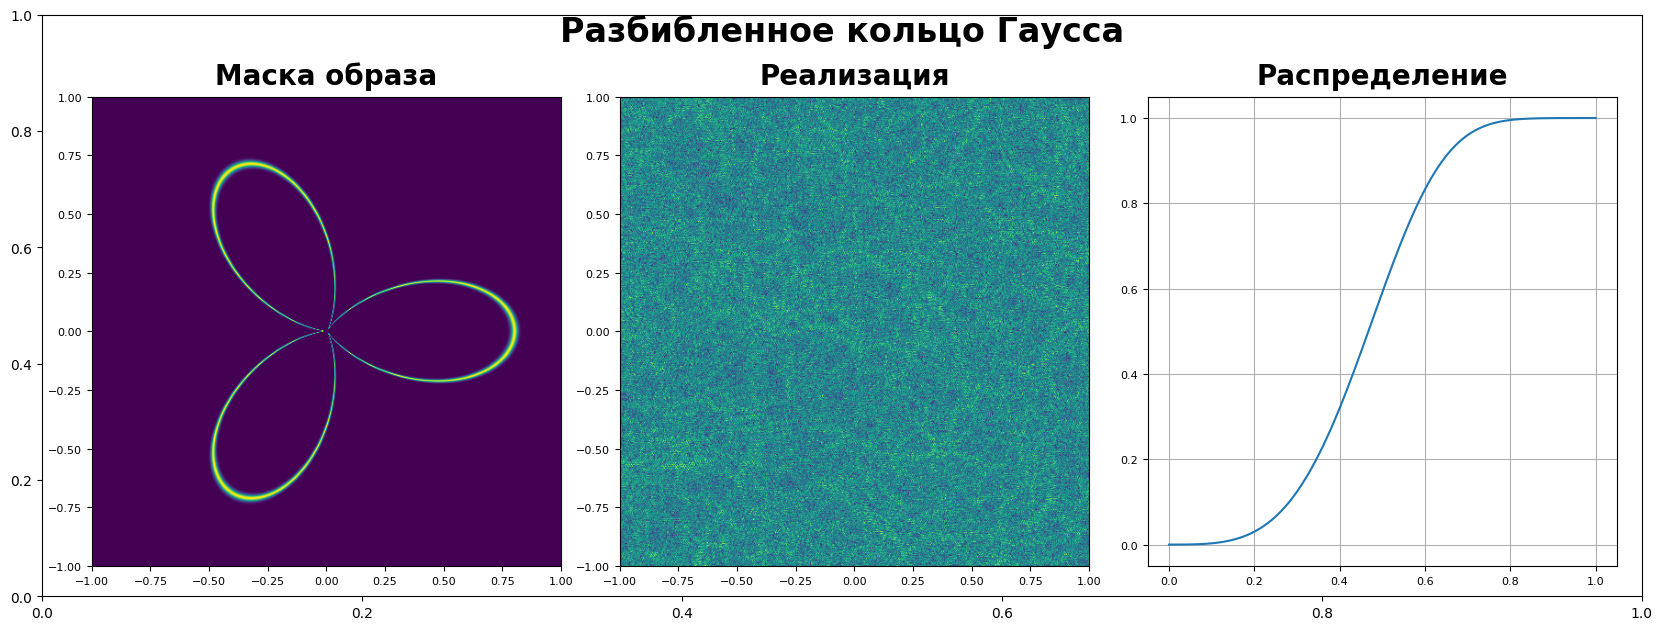

In [9]:
sigma = 0.01
r0 = 0.4
dr = 0.4
times = 3
kernel = torch.exp(-0.5*(torch.abs(r_mesh - r0 + dr*torch.sin(times*phi_mesh))/sigma)**2) / (sigma * math.sqrt(2*math.pi))
show(kernel, samples=samples, title='Разбибленное кольцо Гаусса')

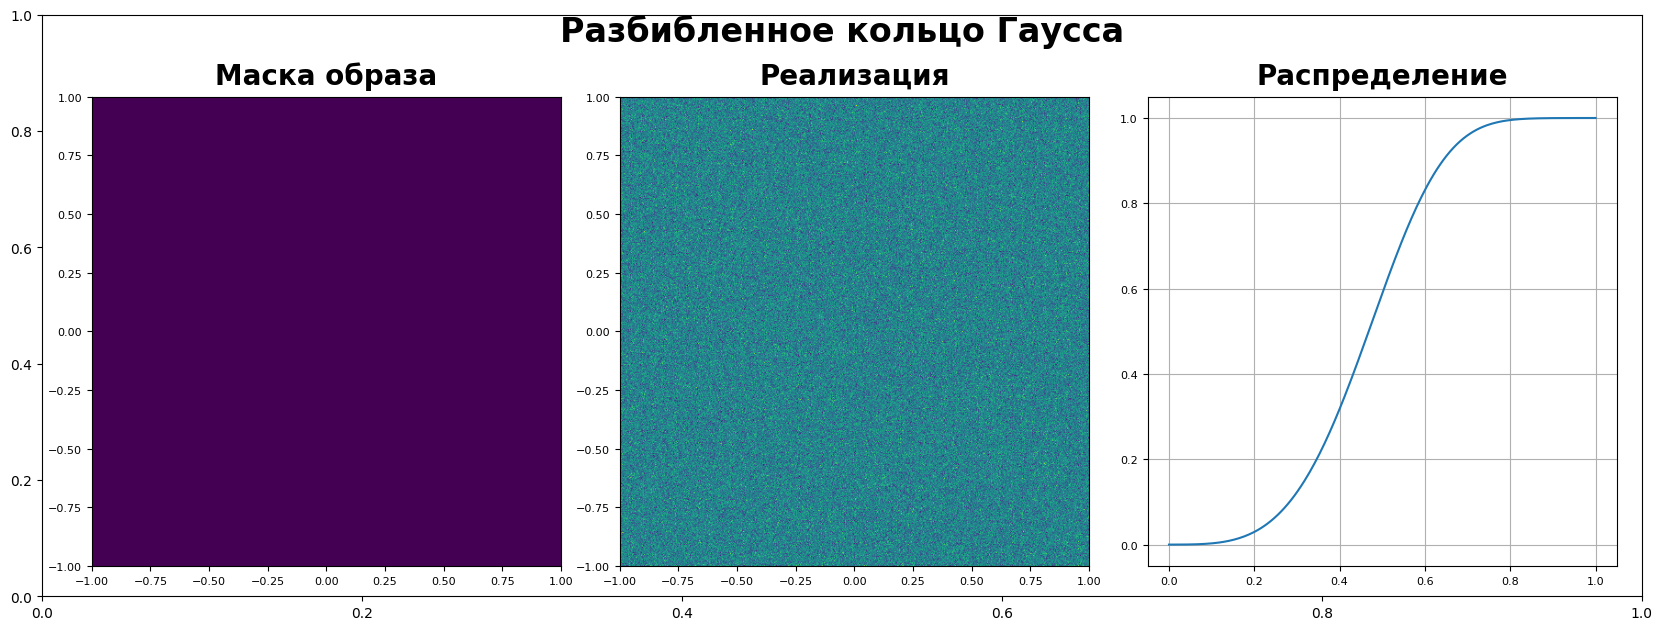

In [10]:
kernel = torch.ones_like(x_mesh)
show(kernel, samples=samples, title='Разбибленное кольцо Гаусса')

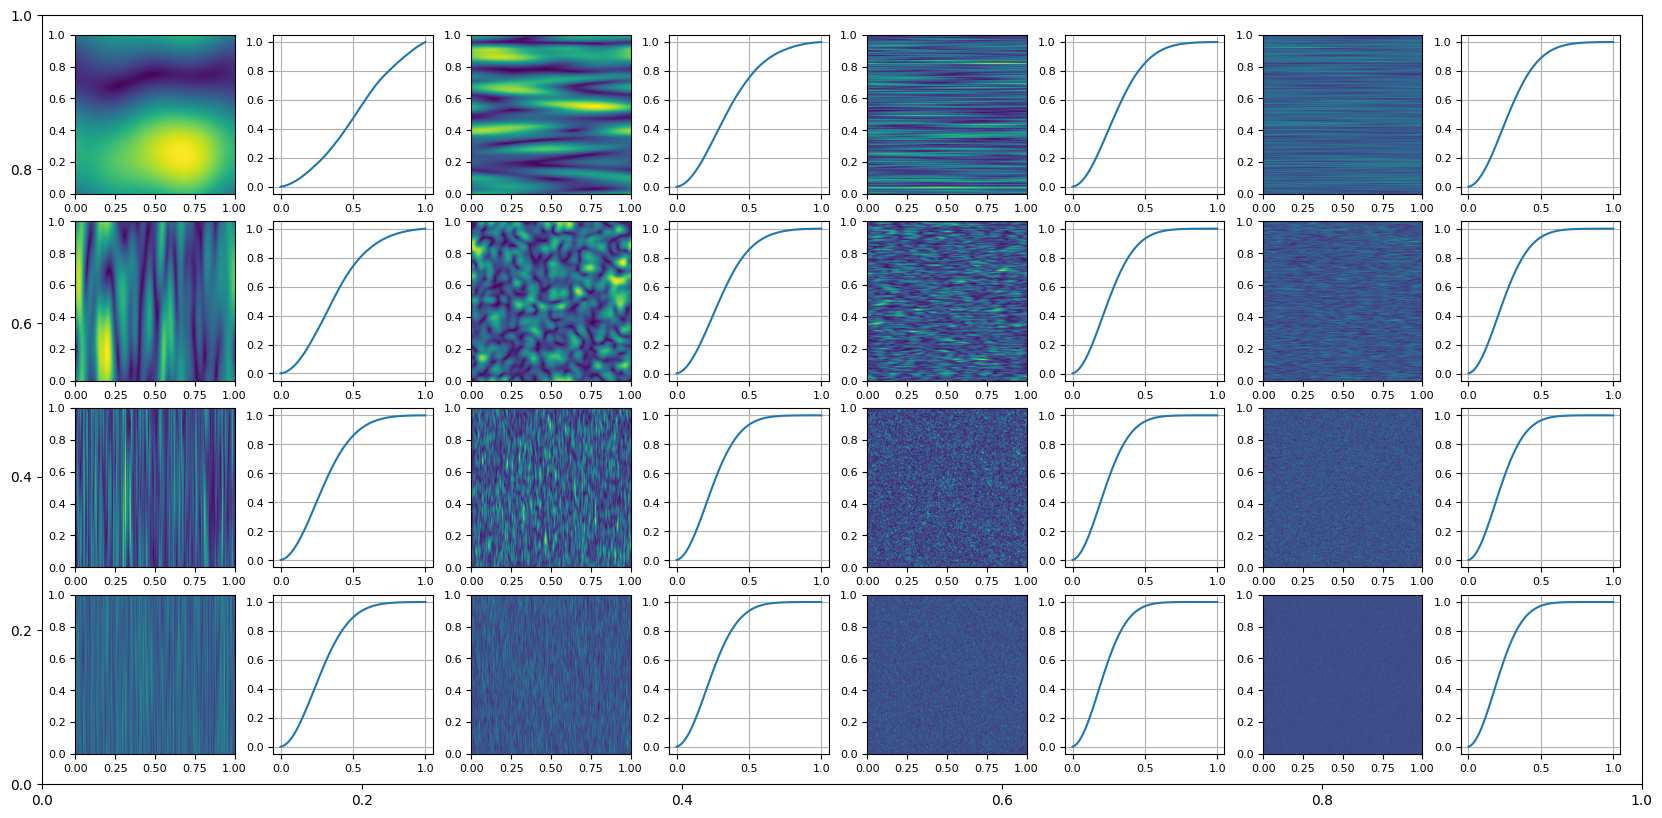

In [11]:
from DNN.src.modules.wrappers.incoherent.noises.fouriers import gaussian
torch.cuda.empty_cache()

N = 1024
samples = 20
M = 100

sigmas = numpy.logspace(-2,1,4)
counts = (N, N)
limits = ((0, 1), (0, 1))

plot = TiledPlot(16, 9)

kwargs = {'aspect':'auto', 'cmap':'viridis', 'extent':[0, 1]*2}
for (col, sigma_x), (row, sigma_y) in product(enumerate(sigmas), enumerate(sigmas)):
    
    with torch.no_grad():
        generator = gaussian((sigma_x, sigma_y), counts, limits, generator=True)
        dist = torch.zeros((M), dtype=torch.float32, device=device)
        for i in range(samples):
            realization = generator.sample()
            realization = (realization - realization.min()) / (realization.max() - realization.min())
            dist += distribution(realization, M)
        dist /= samples
        dist = dist.cpu()
        realization = realization.cpu()
    
    axes = plot.axes.add(2*col, row)
    axes.imshow(realization, **kwargs)
    
    axes = plot.axes.add(2*col+1, row)
    axes.grid(True)
    axes.plot(numpy.linspace(0, 1, M), dist)
    
plot.show()